### Configuration & Imports

In [1]:
# In[1]:
from pathlib import Path
from typing import List, Tuple

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from scipy.optimize import curve_fit
from skgstat.models import exponential

# --- Plotting Style ---
plt.style.use("seaborn-v0_8-talk")
plt.rcParams["figure.figsize"] = (12, 5)


class Config:
    """A centralized class for all user-configurable parameters."""

    # --- 1. SET YOUR FILE PATHS HERE ---
    SHAPEFILE_PATH = Path(
        r"D:\1000_SCRIPTS\003_Project002\20250222_GTWR001\2_KrigingInterpolation\points_fld\mlcw_twd97.shp"
    )
    MODEL_FOLDER = Path(
        r"D:\1000_SCRIPTS\003_Project002\20250222_GTWR001\5_GTWR_Prediction"
    )

    # --- 2. DEFINE YOUR ANALYSIS SETTINGS ---
    KERNEL_NAME: str = "bisquare"
    START_DATE = pd.Timestamp(year=2016, month=5, day=1)

    # --- 3. CHOOSE WHICH POINT TO ANALYZE ---
    # Change these indices to analyze a different file or a different point
    SELECT_FILE_INDEX: int = 0
    SELECT_POINT_INDEX: int = 7


print("✅ Configuration and libraries loaded.")

✅ Configuration and libraries loaded.


### Core Functions

In [2]:
# In[2]:
def load_and_prepare_data(file_path: Path) -> pd.DataFrame:
    """Loads CSV data, creates a 'PointKey', and sets it as the index."""
    df = pd.read_csv(file_path)
    pointkey_arr = [f"X{int(x*1000)}Y{int(y*1000)}" for x, y in zip(df["X_TWD97"], df["Y_TWD97"])]
    df.insert(loc=0, column="PointKey", value=pointkey_arr)
    df.set_index("PointKey", inplace=True)
    return df

def get_time_series_for_point(df: pd.DataFrame, point_key: str, start_date: pd.Timestamp) -> Tuple[pd.Series, np.ndarray]:
    """
    Extracts the time series for a single point, prepares it for analysis,
    and calculates the cumulative time in days.
    """
    df_point = df.loc[point_key].copy()
    
    time_arr = [start_date + relativedelta(months=int(t)) for t in df_point["time_stamp"]]
    df_point["datetime"] = time_arr
    df_point = df_point.set_index("datetime").sort_index()
    
    coefficient_series = df_point["CUMDISP"].asfreq("MS")
    
    # **This calculation now exactly matches your original logic.**
    time_days = pd.Series(coefficient_series.index).diff().apply(lambda x: x.days).fillna(0).cumsum().values
    
    return coefficient_series, time_days

def fit_exponential_model(series: pd.Series, time_days: np.ndarray) -> Tuple[np.ndarray, pd.Series]:
    """
    Fits an exponential variogram model using the original logic for bounds and p0.
    """
    valid_mask = ~np.isnan(series)
    y_data = series[valid_mask]
    x_data = time_days[valid_mask]

    if len(y_data) < 3:
        raise ValueError("Not enough valid data points to fit the model.")

    # **Set up bounds and initial guess exactly as in the original script.**
    parameter_bounds = (
        [np.min(x_data), np.min(y_data), np.min(y_data)],
        [np.max(x_data), np.max(y_data), np.max(y_data)],
    )
    initial_guess = [np.median(x_data), np.median(y_data), y_data.iloc[0]]

    params, _ = curve_fit(
        exponential,
        x_data,
        y_data,
        p0=initial_guess,
        bounds=parameter_bounds,
    )
    
    predictions = pd.Series(data=exponential(time_days, *params), index=series.index)
    return params, predictions

def plot_data(original_series: pd.Series, predicted_series: pd.Series, title: str):
    """Generates a plot of the original vs. fitted data."""
    plt.figure()
    original_series.plot(marker='o', linestyle='-', label='Original Data', markerfacecolor='none', color='gray', alpha=0.8)
    predicted_series.plot(label='Fitted Exponential Model', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Displacement (CUMDISP)")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

print("✅ Helper functions defined (with corrected fitting logic).")

✅ Helper functions defined (with corrected fitting logic).


#### Step 1 - Find and Select Data File

In [3]:
# In[3]:
# Find all files matching the kernel name in the model folder
output_files = sorted(
    list(Config.MODEL_FOLDER.glob(f"*{Config.KERNEL_NAME}*.csv"))
)
if not output_files:
    raise FileNotFoundError(
        f"No files with kernel '{Config.KERNEL_NAME}' found in {Config.MODEL_FOLDER}"
    )

# Select the file based on the index set in the Config
selected_file = output_files[Config.SELECT_FILE_INDEX]

print(f"Found {len(output_files)} files. Analyzing:")
print(f"-> {selected_file.name}")

Found 4 files. Analyzing:
-> gtwr_Layer_1_kernel-bisquare_lambda-0d006_bw-23_coefficients.csv


#### Step 2 - Load Data and Analyze a Single Point

In [6]:
# In[4]:
df_processed = load_and_prepare_data(selected_file)
mlcw_gdf = gpd.read_file(Config.SHAPEFILE_PATH)

unique_point_keys = sorted(df_processed.index.unique())
selected_point_key = unique_point_keys[Config.SELECT_POINT_INDEX]
station_name = mlcw_gdf.query("PointKey == @selected_point_key").STATION.values[0]

print(f"Analyzing Station: '{station_name}' (PointKey: {selected_point_key})")

# Prepare the data series and time_days array for this specific point
coefficient_series, time_days = get_time_series_for_point(df_processed, selected_point_key, Config.START_DATE)

print("\nOriginal Data Series (first 5 rows):")
display(coefficient_series.head())

Analyzing Station: 'XIGANG' (PointKey: X177634127Y2639733171)

Original Data Series (first 5 rows):


datetime
2016-06-01   -0.073482
2016-07-01   -0.005287
2016-08-01   -0.003389
2016-09-01   -0.003002
2016-10-01   -0.006207
Freq: MS, Name: CUMDISP, dtype: float64

####  Step 3 - Fit Model and Display Results

--- Model Fit Results (Original Logic) ---
Fitted Parameters (Range, Sill, Nugget): [ 5.454853e+02  3.700000e-02 -3.480000e-02]


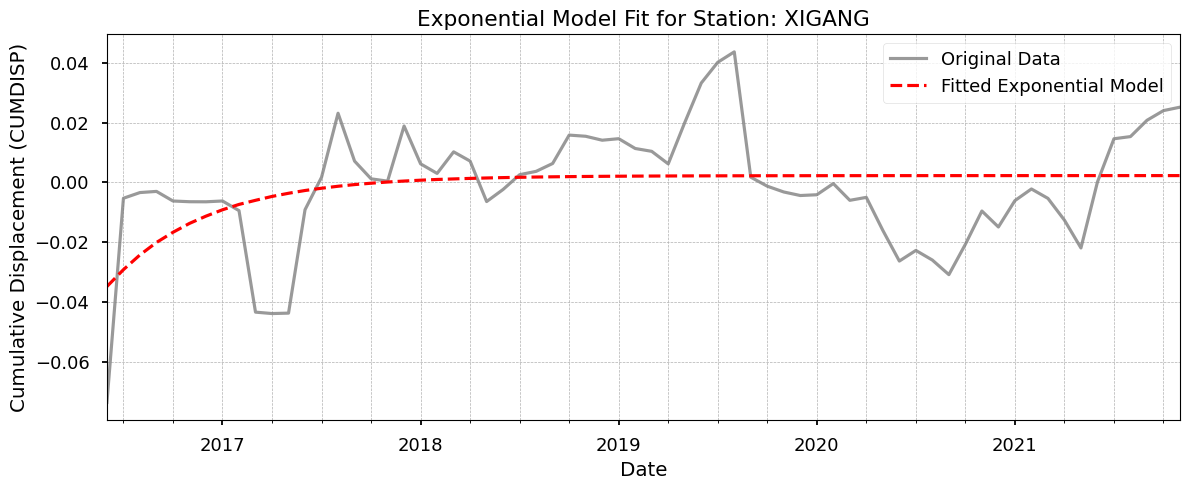

In [7]:
# In[5]:
try:
    # Fit the model using the series and the separately calculated time_days
    fitted_params, predicted_values = fit_exponential_model(coefficient_series, time_days)

    print("--- Model Fit Results (Original Logic) ---")
    print(f"Fitted Parameters (Range, Sill, Nugget): {np.round(fitted_params, 4)}")
    
    plot_title = f"Exponential Model Fit for Station: {station_name}"
    plot_data(coefficient_series, predicted_values, plot_title)

except ValueError as e:
    print(f"Error: Could not fit model. {e}")
except RuntimeError as e:
    print(f"Error: Fitting failed to converge. {e}")